In [42]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [21]:
# Read the CSV file
csv_files_path = "./data/listings.csv"

listing_data = pd.read_csv(csv_files_path)

In [54]:
correlation = listing_data.corr()

# Plot heatmap
plt.figure(figsize=(128, 128))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('unprocessed_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\tommy\AppData\Local\Temp\ipykernel_17384\1856233424.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = listing_data.corr()


In [22]:
processed_df = listing_data.drop(columns=["host_url", "host_since", "host_name", "host_location", "host_about", "scrape_id", "last_scraped", "source", 
                                          "host_thumbnail_url", "host_picture_url", "listing_url", "scrape_id", "last_scraped", "source", "description", "name",
                                          "neighborhood_overview", "picture_url", "host_neighbourhood", "host_verifications", "neighbourhood", "neighbourhood_group_cleansed",
                                          "latitude", "longitude", "room_type", "bathrooms", "bedrooms", "amenities", "minimum_nights", "maximum_nights",
                                          "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm",
                                          "maximum_nights_avg_ntm", "calendar_updated", "has_availability", "availability_30", "availability_60", "availability_90",
                                          "calendar_last_scraped", "first_review", "last_review", "license", "instant_bookable", "calculated_host_listings_count",
                                          "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms"])

# ordinal mapping - bathroom_text, host_response_time
# one-hot - property_type
# changing t/f to 1/0 - host_is_superhost, host_has_profile_pic, host_identity_verified "availability_60", "availability_365",
# correlation w price - neighbourhood

In [23]:
processed_df = processed_df[(processed_df['availability_365'] != 0) & (processed_df['availability_365'] != 365)]

In [24]:
property_types_to_drop = ["boat", "casa particular", "aparthotel", "earthen home", "barn", "tiny home", "castle", "camper/rv", "island"]
property_type_counts = processed_df['property_type'].value_counts()
property_types_to_keep = property_type_counts[property_type_counts >= 20].index.tolist()
processed_df = processed_df[processed_df['property_type'].isin(property_types_to_keep)]    

In [25]:
def is_shared_bathroom(text):
    if pd.isnull(text):
        return None
    elif "shared" in text.lower():
        return 1
    else:
        return 0

bathroom_mapping = {float('nan'): float('nan'), '0 shared baths': 0,
                    'Shared half-bath': 0.5, 'Half-bath': 0.5, '1 shared bath': 1, '1 bath': 1, '1 private bath': 1,  
                    '1.5 shared baths': 1.5, '1.5 baths': 1.5,
                    '2 shared baths': 2, '2 baths': 2, '2.5 baths': 2.5,
                    '3 baths': 3, '3.5 baths': 3.5,  
                    '4 baths': 4, '4.5 baths': 4.5,
                    '4.5 shared baths': 4.5, '5 baths': 5,
                    '3 shared baths': 3, 'Private half-bath': 0.5, '0 baths': 0,
                    '8 baths': 8, '6 baths': 6, '2.5 shared baths': 2.5,
                    '3.5 shared baths': 3.5, '5.5 baths': 5.5, '6.5 baths': 6.5,
                    '4 shared baths': 4, '7 baths': 7}

processed_df['is_shared_bathroom'] = processed_df['bathrooms_text'].apply(is_shared_bathroom)
processed_df['bathrooms_ordinal'] = processed_df['bathrooms_text'].map(bathroom_mapping)
processed_df.drop(columns=['bathrooms_text'], inplace=True)

In [26]:
response_mapping = {'within an hour': 5, 'within a few hour': 4, 'within a day': 3, 'a few days or more': 2, float('nan'): 1}
processed_df['response_time_ordinal'] = processed_df['host_response_time'].map(response_mapping)
processed_df.drop(columns=['host_response_time'], inplace=True)

In [27]:
one_hot_encoded_df = pd.get_dummies(processed_df['property_type'])
processed_df = pd.concat([processed_df, one_hot_encoded_df], axis=1)
processed_df.drop(columns=['property_type'], inplace=True)

In [28]:
replace_cols = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified"]
processed_df[replace_cols] = processed_df[replace_cols].replace({'t': 1, 'f': 0})

In [29]:
cols_to_inject = ["host_response_rate", "host_acceptance_rate"]
for col in cols_to_inject:
    processed_df[col] = processed_df[col].str.rstrip('%').astype(float) / 100

temp_data = processed_df[cols_to_inject]
average_values = temp_data.dropna()[cols_to_inject].mean()
processed_df['host_response_rate'].fillna(average_values[0], inplace=True)
processed_df['host_acceptance_rate'].fillna(average_values[1], inplace=True)

In [30]:
processed_df['price'] = processed_df['price'].str.replace('$', '')
processed_df['price'] = processed_df['price'].str.replace(',', '').astype(float)

C:\Users\tommy\AppData\Local\Temp\ipykernel_17384\3095121920.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  processed_df['price'] = processed_df['price'].str.replace('$', '')


In [31]:
neighbourhood_data = processed_df[["neighbourhood_cleansed", "price"]]
one_hot_encoded_df = pd.get_dummies(neighbourhood_data['neighbourhood_cleansed'])
neighbourhood_data = pd.concat([neighbourhood_data, one_hot_encoded_df], axis=1)
neighbourhood_data = neighbourhood_data.drop(columns=["neighbourhood_cleansed"])
correlation = neighbourhood_data.corr()
correlation = correlation["price"][1:]

In [32]:
corr_dict = correlation.to_dict()
processed_df['neighbourhood_cleansed'] = processed_df['neighbourhood_cleansed'].map(corr_dict)

In [33]:
processed_df = processed_df.dropna() 
processed_df.to_csv("./data/processed_listings.csv")

In [ ]:
scaler = MinMaxScaler()
processed_df_normalized = processed_df.copy()
processed_df_normalized[processed_df.columns] = scaler.fit_transform(processed_df_normalized)

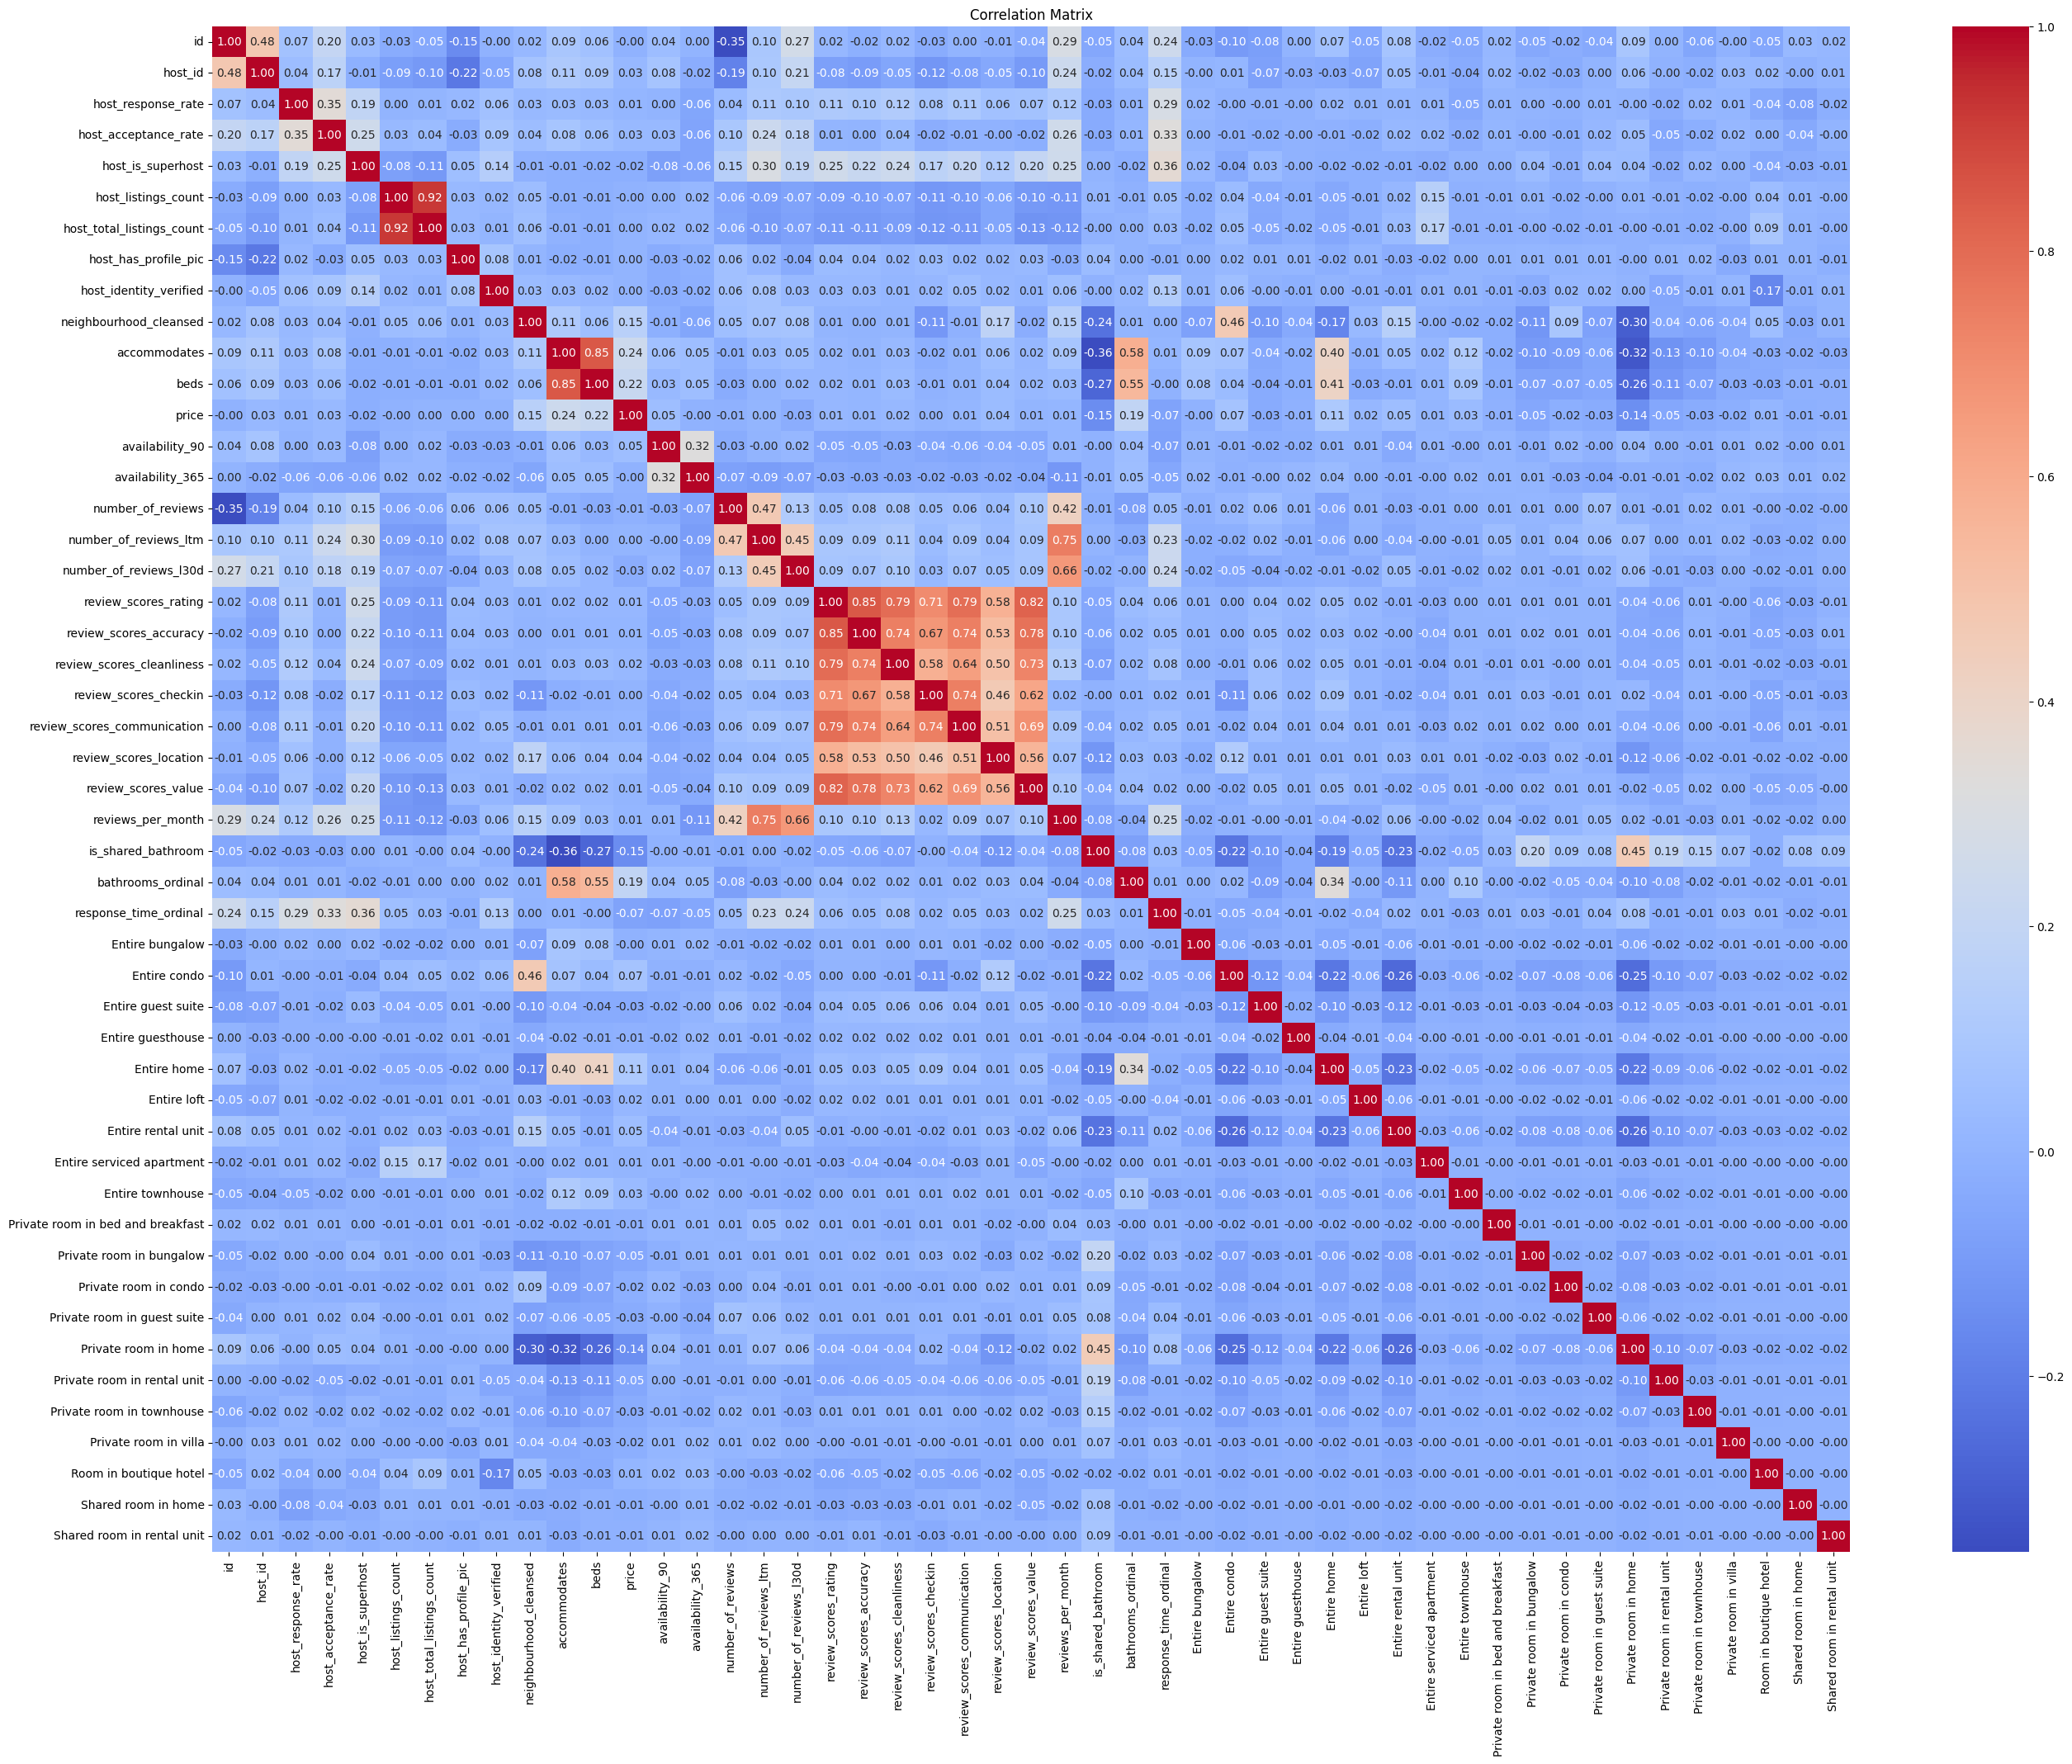

In [52]:
correlation = processed_df_normalized.corr()

# Plot heatmap
plt.figure(figsize=(32, 24))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
X = processed_df.drop(columns=['availability_365'])  # Features (all columns except 'availability_90')
y = processed_df['availability_365']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data into training and testing sets

# Step 3: Choose Model
model = DecisionTreeRegressor(random_state=69)  

# Step 4: Train Model
model.fit(X_train, y_train)  # Train the model on the training data

# Step 5: Evaluate Model
y_pred = model.predict(X_test)  # Make predictions on the testing data
mae = mean_absolute_error(y_test, y_pred)  # Calculate Mean Absolute Error
print("Mean Absolute Error:", mae)

Mean Absolute Error: 105.0242747187685


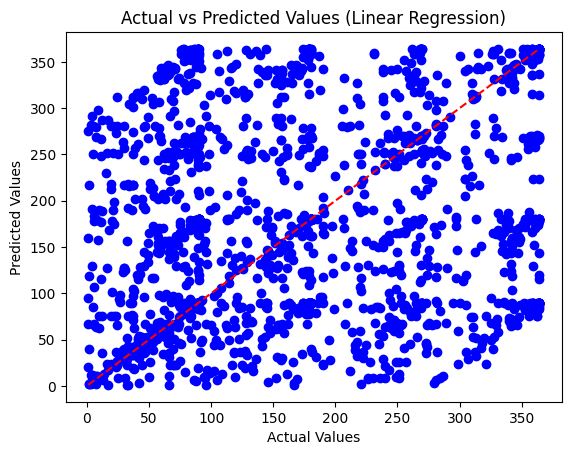

In [44]:
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Linear Regression)')
plt.show()

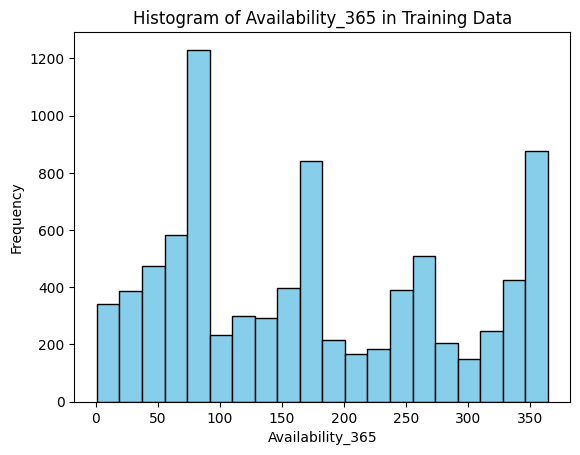

In [37]:
a365 = processed_df["availability_365"]
plt.hist(a365, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Availability_365')
plt.ylabel('Frequency')
plt.title('Histogram of Availability_365 in Training Data')
plt.show()

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Choose Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer with one neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Train Model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)  # Train the model on the training data

# Step 5: Evaluate Model
mse = model.evaluate(X_test_scaled, y_test)  # Evaluate the model on the testing data
print("Mean Squared Error:", mse)

Epoch 1/50
169/169 [==============================] - 1s 2ms/step - loss: 32012.3086 - val_loss: 13586.0508
Epoch 2/50
169/169 [==============================] - 0s 856us/step - loss: 11792.6494 - val_loss: 11030.2021
Epoch 3/50
169/169 [==============================] - 0s 870us/step - loss: 11003.2725 - val_loss: 10853.9971
Epoch 4/50
169/169 [==============================] - 0s 855us/step - loss: 10740.0918 - val_loss: 10795.6035
Epoch 5/50
169/169 [==============================] - 0s 863us/step - loss: 10605.7012 - val_loss: 10689.5918
Epoch 6/50
169/169 [==============================] - 0s 869us/step - loss: 10482.8887 - val_loss: 10645.7578
Epoch 7/50
169/169 [==============================] - 0s 880us/step - loss: 10412.8213 - val_loss: 10626.7510
Epoch 8/50
169/169 [==============================] - 0s 869us/step - loss: 10321.4951 - val_loss: 10593.7285
Epoch 9/50
169/169 [==============================] - 0s 870us/step - loss: 10263.8281 - val_loss: 10594.3066
Epoch 10/50
